# Text preprocessing

In [ ]:
import os
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [8]:
def tokenize(text):
    """
    Tokenize, lemmatize, remove stopwords and punctuations from an input text.
    
    Parameters
    ----------
    text: str, input text
    
    Returns
    -------
    str, preprocessed text
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    tokens = nltk.word_tokenize(text)
    text = [word for word in tokens if word not in string.punctuation]
    
    return " ".join([lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words])

In [16]:
def preprocess_summaries(readpath, savepath=None):
    """
    Preprocess all movie summaries.
    
    Parameters
    ----------
    readpath: str, path to original summaries (.txt)
    savepath: str, path to preprocessed summaries (.csv)
    
    Returns
    -------
    original_summaries: list, original summaries
    df: pandas.DataFrame, preprocessed summaries with movie_id as index
    """
    with open(readpath, encoding='utf-8') as f:
        content = f.readlines()
    original_summaries = [x.strip() for x in content] 
    summaries = [tokenize(d).split() for d in original_summaries]
    summaries = {summary[0]: " ".join(summary[1:]) for summary in summaries}
    
    df = pd.DataFrame.from_dict(summaries, orient='index', columns=['text'])
    df.index = df.index.astype('int64').rename('movie_id')
    
    if savepath is not None:
        df.to_csv(savepath)
    return original_summaries, df

In [17]:
readpath = "./data/plot_summaries.txt"
savepath = "./generated/summaries.csv"
os.makedirs("./generated/", exist_ok=True)

original_summaries, summaries = preprocess_summaries(readpath, savepath)

In [18]:
original_summaries[0] # original

"23890098\tShlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."

In [20]:
summaries.iloc[0]['text'] # preprocessed

"shlykov hard-working taxi driver lyosha saxophonist develop bizarre love-hate relationship despite prejudice realize n't different"

# Join movie metadata

In [1]:
import pandas as pd

In [12]:
colnames = ['movie_id', 'freebase_id', 'movie_name', 'date', 'revenue', 'runtime', 'language', 'country', 'genre']
metadata = pd.read_csv('./data/movie.metadata.tsv',
                    sep='\t',
                    header=None,
                    names=colnames)
# convert "genre" column to dictionary and expand it into new rows
metadata.genre = metadata.genre.apply(lambda x: list(eval(x).values()))
metadata = metadata.explode('genre').reset_index(drop=True)
metadata.head()

,movie_id,freebase_id,movie_name,date,revenue,runtime,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Thriller
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Science Fiction
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Horror
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Adventure
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Supernatural


In [14]:
summary = pd.read_csv("./generated/summaries.csv")
summary_metadata = summary.merge(metadata, on="movie_id", how="inner")
print("Number of movies with summary: {}".format(len(summary_metadata.movie_id.unique())))

Number of movies with summary: 42207


# Regression analysis

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
intensity = pd.read_csv("./generated/MovieIDs_emotions.csv")
intensity.head()

,Movie ID,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,23890098,0.545,0.508,0.000,0.000,0.514,0.000,0.578,0.656
1,31186339,21.194,12.817,8.796,28.742,13.018,16.055,7.102,17.189
2,20663735,12.641,6.514,3.917,14.270,10.557,11.749,3.398,17.851
3,2231378,10.029,14.450,3.774,11.866,42.855,8.775,6.217,14.474
4,595909,6.694,7.516,2.769,7.930,8.273,8.365,2.320,15.985


Prior to performing regression analysis, we first normalize the intensity scores such that the scores for each movie sum up to 1. In this way the intensity score indicates a relative strength of each emotion in the movie summary, and we ensure that the coefficients for different emotions obtained from regression analysis are comparable.

In [6]:
# Normalize intensity scores by the sum for each movie
intensity.iloc[:, 1:] = intensity.iloc[:, 1:].div(intensity.iloc[:, 1:].sum(axis=1), axis=0)
intensity.head()

,Movie ID,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,23890098,0.194573,0.181364,0.000000,0.000000,0.183506,0.000000,0.206355,0.234202
1,31186339,0.169670,0.102607,0.070417,0.230096,0.104217,0.128529,0.056856,0.137608
2,20663735,0.156260,0.080522,0.048420,0.176397,0.130499,0.145234,0.042004,0.220663
3,2231378,0.089194,0.128513,0.033565,0.105532,0.381137,0.078042,0.055292,0.128726
4,595909,0.111843,0.125576,0.046264,0.132493,0.138224,0.139761,0.038762,0.267075


The box office revenues are normalized to the range of [0, 1] by min-max normalization for easier interpretation of regression coefficients. In total, we have 7588 movies with intensity scores and box office revenue available for this analysis.

In [15]:
# Merge
df = metadata.merge(intensity, left_on="movie_id", right_on="Movie ID", how="inner").drop(columns=["Movie ID"])
print("Number of movies with intensity scores: {}".format(len(df.movie_id.unique())))
df = df[~df.revenue.isna()]
print("Number of movies with intensity scores, and revenue: {}".format(len(df.movie_id.unique())))

# Normalize revenues to the range [0, 1]
def minmax_normalize_df(df, columns):
    df_norm = df.copy()
    for column in columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
    return df_norm

df = minmax_normalize_df(df, ["revenue"])
df.head()

Number of movies with intensity scores: 42202
Number of movies with intensity scores, and revenue: 7588


,movie_id,freebase_id,movie_name,date,revenue,runtime,language,country,genre,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,0.005032,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Thriller,0.199208,0.040236,0.088978,0.290556,0.042002,0.16037,0.018043,0.160606
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,0.005032,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Science Fiction,0.199208,0.040236,0.088978,0.290556,0.042002,0.16037,0.018043,0.160606
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,0.005032,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Horror,0.199208,0.040236,0.088978,0.290556,0.042002,0.16037,0.018043,0.160606
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,0.005032,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Adventure,0.199208,0.040236,0.088978,0.290556,0.042002,0.16037,0.018043,0.160606
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,0.005032,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Supernatural,0.199208,0.040236,0.088978,0.290556,0.042002,0.16037,0.018043,0.160606


There exist a total of 364 genres in the original movie metadata, some of which may not be meaningful. We focus on the top-10 genres that appear most frequent in the metadata.

In [10]:
top10_genres = list(summary_metadata.groupby("genre").size().sort_values(ascending=False)[:10].index)
print(top10_genres)

['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror', 'Black-and-white', 'Indie']


OLS regression is performed for each genre on the box office revenue with the intensity score of 8 emotions as independent variables. Note that we consider **all** movies that are labeled with each genre. The number of movies per genre varies from 294 to 3953. The adjusted $R^2$ is generally very low, with a maximum of 0.031 for the *Crime Fiction* genre. 

In [9]:
# OLS regression
params = {}
pvalues = {}
stats = []

for genre in top10_genres:
    df_group = df.groupby("genre").get_group(genre)
    mod = smf.ols(formula="revenue ~ anger + anticipation + disgust + fear + joy + sadness + surprise + trust",
                    data=df_group)
    res = mod.fit()
    params[genre] = res.params.iloc[1:]
    pvalues[genre] = res.pvalues.iloc[1:]
    stats.append({"genre": genre, "adj. R-square": res.rsquared_adj, "num. movies": len(df_group)})
    
for item in stats:
    print("{:<15}: adj. R-square = {:.3f}, num. movies = {}".format(
        item["genre"], item["adj. R-square"], item["num. movies"]))

Drama          : adj. R-square = 0.009, num. movies = 3953
Comedy         : adj. R-square = 0.009, num. movies = 2944
Romance Film   : adj. R-square = 0.003, num. movies = 1863
Thriller       : adj. R-square = 0.016, num. movies = 1877
Action         : adj. R-square = 0.008, num. movies = 1657
World cinema   : adj. R-square = 0.002, num. movies = 522
Crime Fiction  : adj. R-square = 0.031, num. movies = 1187
Horror         : adj. R-square = 0.005, num. movies = 749
Black-and-white: adj. R-square = 0.004, num. movies = 294
Indie          : adj. R-square = 0.020, num. movies = 946


In [10]:
df_params = pd.DataFrame.from_dict(params)
df_params

,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror,Black-and-white,Indie
anger,0.013994,-0.000523,0.025216,0.024438,-0.033851,0.018915,-0.005608,-0.000258,-0.033946,0.021130
anticipation,0.007767,0.016708,0.020737,0.038918,0.065189,0.008619,0.049545,0.014352,-0.001271,-0.002583
disgust,-0.034135,-0.022357,-0.020470,-0.159736,-0.120932,-0.001965,-0.156167,-0.067283,0.022074,0.009238
fear,0.030403,0.029579,0.021772,0.064958,0.025908,0.002808,0.042363,0.050952,0.006814,0.013794
joy,-0.009697,-0.006787,-0.010993,-0.027629,-0.041489,-0.004265,-0.036290,0.040390,-0.000874,0.004347
sadness,-0.006714,-0.009300,-0.020705,-0.000568,0.087074,-0.011144,0.033184,0.000304,0.015110,-0.022576
surprise,0.023515,0.035128,0.011890,0.044268,0.061759,0.004930,0.074091,-0.018960,-0.004519,-0.005282
trust,-0.011790,-0.023314,-0.010978,0.024892,-0.018304,-0.010459,0.007889,-0.011992,-0.000483,-0.012419


In [11]:
df_pvalues = pd.DataFrame.from_dict(pvalues)
df_pvalues

,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror,Black-and-white,Indie
anger,0.281028,0.974197,0.239512,0.371609,0.317989,0.177738,8.109314e-01,0.993422,0.026143,0.058296
anticipation,0.445701,0.174351,0.144865,0.107704,0.058443,0.470196,3.996706e-02,0.602353,0.908318,0.738994
disgust,0.054903,0.263761,0.486011,0.000004,0.005587,0.915295,1.269447e-07,0.035290,0.214643,0.533939
fear,0.006677,0.018342,0.211094,0.002342,0.402370,0.815493,2.506159e-02,0.013437,0.567816,0.132468
joy,0.190675,0.426327,0.320568,0.203255,0.145288,0.618910,4.608479e-02,0.092979,0.927328,0.438475
sadness,0.600041,0.540223,0.271225,0.983923,0.022049,0.402839,1.746756e-01,0.991432,0.273332,0.019725
surprise,0.140712,0.053694,0.602282,0.181278,0.173594,0.765052,1.753336e-02,0.596312,0.789209,0.667818
trust,0.079642,0.002360,0.282577,0.143995,0.384204,0.160803,5.789520e-01,0.547561,0.952198,0.024008


The heatmap shows the OLS regression coefficients for each emotion and each genre. Note that for some of the coefficients, we cannot reject the null hypothesis that they are equal to zero, as indicated by the $p$-value table.

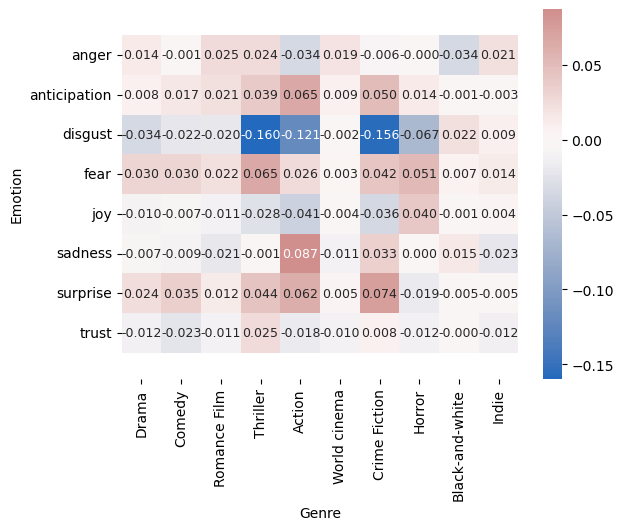

In [12]:
plt.figure()
ax = sns.heatmap(df_params, annot=True, center=0., cmap="vlag", fmt='.3f', annot_kws={"fontsize":9})
ax.set(xlabel="Genre", ylabel="Emotion")
plt.axis('equal')
plt.show()

To draw a valid conclusion on the relationship between box office revenue and emotion intensities, we filter the regression coefficients by the associated $p$-value with threshold 0.05. The filtered heatmap shows a negative effect of the emotion *disgust* on box office revenue of *Thriller*, *Action*, *Crime Fiction*, and *Horror* movies, while increasing intensity of *fear* is associated with higher box office revenue for *Drama*, *Comedy*, *Thriller*, *Crime Fiction*, and *Horror* movies. The intensity of other emotions also exihibit significant relationship with the box office revenue of a few genres.

In [14]:
# Plot heatmap only for coefficients with p-value < 0.05
df_heatmap = df_params.copy()
mask = df_pvalues < 0.05
df_heatmap = df_heatmap[mask]

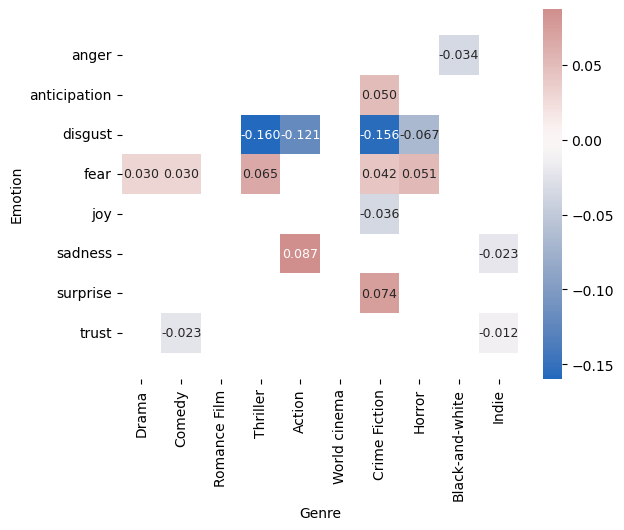

In [15]:
plt.figure()
ax = sns.heatmap(df_heatmap, annot=True, center=0., cmap="vlag", fmt='.3f', annot_kws={"fontsize":9})
ax.set(xlabel="Genre", ylabel="Emotion")
plt.axis('equal')
plt.show()

The regression analysis is repeated considering only the **first** genre associated with each movie. Much fewer movies are retained for this analysis and the number of movies for *Action*, *World cinema*, *Black-and-White*, and *Indie* may not be representative.

In [20]:
# Retain the first genre for each movie, assume it is the main genre
df = df.drop_duplicates("movie_id")

# OLS regression
params = {}
pvalues = {}
stats = []

for genre in top10_genres:
    df_group = df.groupby("genre").get_group(genre)
    mod = smf.ols(formula="revenue ~ anger + anticipation + disgust + fear + joy + sadness + surprise + trust",
                    data=df_group)
    res = mod.fit()
    params[genre] = res.params.iloc[1:]
    pvalues[genre] = res.pvalues.iloc[1:]
    stats.append({"genre": genre, "adj. R-square": res.rsquared_adj, "num. movies": len(df_group)})
    
for item in stats:
    print("{:<15}: adj. R-square = {:.3f}, num. movies = {}".format(
        item["genre"], item["adj. R-square"], item["num. movies"]))

df_params = pd.DataFrame.from_dict(params)
df_pvalues = pd.DataFrame.from_dict(pvalues)

Drama          : adj. R-square = 0.000, num. movies = 517
Comedy         : adj. R-square = 0.094, num. movies = 126
Romance Film   : adj. R-square = -0.007, num. movies = 184
Thriller       : adj. R-square = 0.014, num. movies = 1509
Action         : adj. R-square = -0.072, num. movies = 54
World cinema   : adj. R-square = -0.064, num. movies = 39
Crime Fiction  : adj. R-square = 0.014, num. movies = 676
Horror         : adj. R-square = 0.025, num. movies = 106
Black-and-white: adj. R-square = 0.149, num. movies = 11
Indie          : adj. R-square = 0.037, num. movies = 78


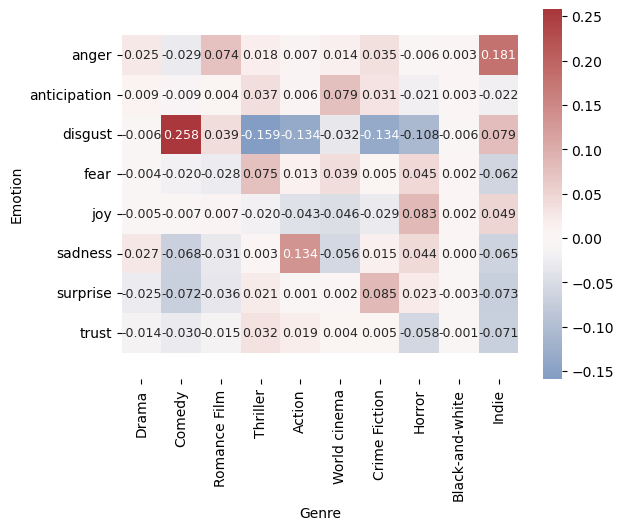

In [21]:
plt.figure()
ax = sns.heatmap(df_params, annot=True, center=0., cmap="vlag", fmt='.3f', annot_kws={"fontsize":9})
ax.set(xlabel="Genre", ylabel="Emotion")
plt.axis('equal')
plt.show()

Few regression coefficients are deemed significant by a $p$-value threshold of 0.05. There is still a negative relationship between *disgust* and box office revenue for *Thriller*, *Crime Fiction*, and *Horror*, but now *disgust* also appears to have a positive relationship with the box office revenue of *Comedy*. *Joy* is positively linked with the revenue of *Horror*. The positive relationship between *fear* and revenue of *Thriller*, *surprise* and *Crime Fiction* are similar to the previous analysis.

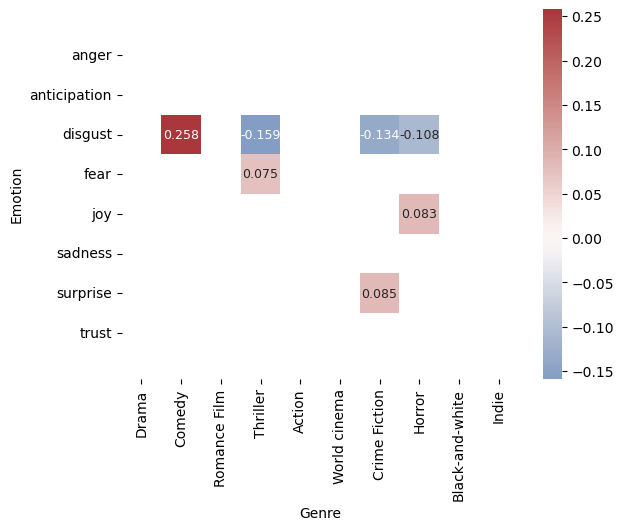

In [22]:
# Plot heatmap only for coefficients with p-value < 0.05
df_heatmap = df_params.copy()
mask = df_pvalues < 0.05
df_heatmap = df_heatmap[mask]

plt.figure()
ax = sns.heatmap(df_heatmap, annot=True, center=0., cmap="vlag", fmt='.3f', annot_kws={"fontsize":9})
ax.set(xlabel="Genre", ylabel="Emotion")
plt.axis('equal')
plt.show()

In [1]:
import pandas as pd

In [2]:
# summaries: preprocessed plot summaries from CMU Movie Summary Corpus
summaries = pd.read_csv("./generated/summaries.csv")

In [3]:
# ratings: movie ratings from Kaggle Movies Dataset
ratings = pd.read_csv("./data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [4]:
# links: mapping between movie identifiers from Kaggle Movies Dataset
links = pd.read_csv("./data/links.csv")
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
# additional: movie metadata from Kaggle Movies Dataset
additional = pd.read_csv("./data/movies_metadata.csv")
additional.head()

C:\Users\Zhang\AppData\Local\Temp\ipykernel_7772\158361551.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  additional = pd.read_csv("./data/movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
# movies: movie metadata from CMU Movie Summary Corpus
colnames = ['movie_id', 'freebase_id', 'movie_name', 'date', 'BOrevenue', 'runtime', 'language', 'country', 'genre']
movies = pd.read_csv('./data/movie.metadata.tsv',
                    sep='\t',
                    header=None,
                    names=colnames)
movies.head()

,movie_id,freebase_id,movie_name,date,BOrevenue,runtime,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [7]:
# merge
movies.movie_name = movies.movie_name.str.lower()
additional.title = additional.title.str.lower()
movies_additional = additional[["title", "imdb_id", "revenue", "release_date"]].merge(
    movies, left_on="title", right_on="movie_name", how='inner')
len(movies_additional)

36572

In [8]:
# remove prefixes and drop NaNs from imdb_id
movies_additional = movies_additional.dropna(subset=['imdb_id']).astype(str).replace(r'^tt0*', '', regex=True)
movies_additional['imdb_id'] = movies_additional['imdb_id'].astype('int64')
len(movies_additional)

36553

In [9]:
# merge
movies_additional.movie_id = movies_additional.movie_id.astype(int)
movies_additional_summaries = movies_additional.merge(summaries, on="movie_id", how="inner")
len(movies_additional_summaries)

25198

In [10]:
# calculate average ratings
mean_ratings = ratings.groupby("movieId").agg(mean_rating=("rating", "mean"))

In [11]:
# merge
imdbid_rating = links.merge(mean_ratings, left_on="movieId", right_on="movieId", how="inner"
                          )[["imdbId", "mean_rating"]]
len(imdbid_rating)

45115

In [12]:
print("Number of movies with summary, metadata, and ratings: {}".format(
    len(set(imdbid_rating.imdbId).intersection(set(movies_additional_summaries.imdb_id)))))

Number of movies with summary, metadata, and ratings: 20603


In [13]:
# merge
result = imdbid_rating.merge(movies_additional_summaries, left_on="imdbId", right_on="imdb_id", how="inner")
print("Number of rows in the final DataFrame: {}".format(len(result)))

Number of rows in the final DataFrame: 24886


In [14]:
print("Percentage of NaN revenue (from additional dataset) in the final DataFrame: {:.2f}%".format(
    100 * sum(result.revenue.isna()) / len(result)))

Percentage of NaN revenue (from additional dataset) in the final DataFrame: 0.00%
